In [1]:
import matplotlib as mpl
# 폰트 설정
mpl.rc('font', family='NanumGothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr

from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation
import import_ipynb
import libs

n_steps_in=24*3
n_steps_out=24
n_step=n_steps_in

fnames=pd.read_table('data/names_72.txt',header=None)
fnames=fnames.values[:,0]
fnames= [fn.replace('json','csv') for fn in fnames]

################################################
#idx
#idx=np.array([0,1,3])#temp,rain,humi
#idx=np.array([3])#humi
#idx=np.array([0,3])#temp, humi
idx=np.array([0])#temp
################################################

#weather data
data_w=libs.get_weather(idx)
#y data
data_hr1=[]
for fn in fnames:
    data_hr1.append(pd.read_csv('data/cv_26/'+fn).values[:,0])
data_hr1=np.array(data_hr1)
data_hr1=np.concatenate((data_hr1,np.zeros((47,1))),axis=1)
print(data_hr1.shape,data_w.shape)

#faltten
data_hr1=data_hr1.reshape((-1,1))#dataset1.flatten()[:,np.newaxis]#(1128, 1)
clip=24*6
data_hr1=data_hr1[:-clip]
# Feature Scaling
sc1 = MinMaxScaler(feature_range = (0, 1))
data_hr_scaled1 = sc1.fit_transform(data_hr1)
data_hr_scaled1.shape,np.min(data_hr_scaled1),np.max(data_hr_scaled1)

################################################
#merge
dataset_scaled1=np.concatenate((data_hr_scaled1,data_w[:-clip]),axis=-1)#w forecasting weather data
#dataset_scaled1=np.concatenate((data_hr_scaled1,data_w[:-clip]),axis=-1)[:,:2]#humi & w/o 
#dataset_scaled1=np.concatenate((data_hr_scaled1,data_w[:-clip]),axis=-1)[:,:3]#humi, temp & w/o
#dataset_scaled1=np.concatenate((data_hr_scaled1,data_w[:-clip]),axis=-1)[:,:4]#humi, temp, rain & w/o
################################################

n_features=dataset_scaled1.shape[1]
#train / test split
n_train=len(dataset_scaled1)-24*10
n_test=len(dataset_scaled1)-n_train
training_set_scaled1=dataset_scaled1[:n_train]
test_set_scaled1=dataset_scaled1[n_train:]
print(training_set_scaled1.shape,test_set_scaled1.shape)

plt.rcParams["figure.figsize"] = (20,3)
for i in range(n_features):
    fig=plt.figure()
    fig.add_subplot(1,1,1).plot(dataset_scaled1[:,i])#hr,기온,고도,전운량,시정
plt.show()

#input/output
X_train = []
y_train = []
for i in range(n_step,22*24-24):
    X_train.append(training_set_scaled1[i-n_step:i])
    y_train.append(training_set_scaled1[i:i+24])
for i in range(22*24+n_step,n_train-24):
    X_train.append(training_set_scaled1[i-n_step:i])
    y_train.append(training_set_scaled1[i:i+24])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], n_features))
print("train",X_train.shape,y_train.shape)#(960, 168, 1),(960,)

X_test = []
y_test=[]
for i in range(n_step, n_test-24+1,24):
    X_test.append(test_set_scaled1[i-n_step:i])
    y_test.append(test_set_scaled1[i:i+24])
X_test,y_test = np.array(X_test),np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], n_features))
print("test",X_test.shape,y_test.shape)

fig=plt.figure()
fig.add_subplot(2,1,1).plot(y_test[:,:,0].flatten())
fig.add_subplot(2,1,2).plot(test_set_scaled1[-y_test.shape[0]*y_test.shape[1]:,0])
plt.show()

Using TensorFlow backend.


importing Jupyter notebook from libs.ipynb
(47, 24) (1128, 2)
(744, 3) (240, 3)


/home/vislab/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

<Figure size 2000x300 with 1 Axes>

train (552, 72, 3) (552, 24, 3)
test (7, 72, 3) (7, 24, 3)


<Figure size 2000x300 with 2 Axes>

# Training

In [2]:
model = Sequential()
#model.add(LSTM(256, activation='relu',dropout=0.5, input_shape=(n_steps_in, n_features)))#9
model.add(LSTM(256, activation='relu',input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(256, activation='relu')))
#model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(1)))

X_train.shape,y_train.shape, np.min(X_train),np.max(X_train),np.min(y_train),np.max(y_train)

((552, 72, 2), (552, 24, 2), 0.0, 1.0, 0.0, 1.0)

In [3]:
model.compile(loss='mse', optimizer='rmsprop')
model.fit(X_train,y_train[:,:,0:1],batch_size=64,epochs=128,validation_data=(X_test,y_test[:,:,:1]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 552 samples, validate on 7 samples
Epoch 1/128





552/552 [==============================] - 3s 6ms/step - loss: 0.0569 - val_loss: 0.0649
Epoch 2/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0529 - val_loss: 0.0673
Epoch 3/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0528 - val_loss: 0.0665
Epoch 4/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0512 - val_loss: 0.0650
Epoch 5/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0520 - val_loss: 0.0655
Epoch 6/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0498 - val_loss: 0.0757
Epoch 7/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0736 - val_loss: 0.0658
Epoch 8/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0498 - val_loss: 0.0657
Epoch 9/128
552/552 [========================

552/552 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0357
Epoch 60/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0581
Epoch 61/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0467
Epoch 62/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0344
Epoch 63/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0346
Epoch 64/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0352
Epoch 65/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0368
Epoch 66/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0347
Epoch 67/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0469
Epoch 68/128
552/552 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 

In [4]:
model.save('model/comp/model2_0.h5')# # of feature=3,5,7,9,?,12,14,16,18

## Result

In [2]:
#a=[1,2,3,4]
#idx=slice(1,3)
#a[idx]
model1=load_model('model/comp/model1_0.h5')#w/ forecasting
model2=load_model('model/comp/model2_0.h5')#w/o
#model2=model

idx=slice(24,4*24)

pred1= model1.predict(X_test)
pred1=pred1.reshape(-1,1)
pred1 = sc1.inverse_transform(pred1)
pred1=pred1[:,0]
pred1=pred1[idx]

pred2= model2.predict(X_test[:,:,:2])#humi
#pred2= model2.predict(X_test[:,:,:3])#humi, temp
#pred2= model2.predict(X_test[:,:,:4])#humi, temp, rain
pred2=pred2.reshape(-1,1)
pred2 = sc1.inverse_transform(pred2)
pred2=pred2[:,0]
pred2=pred2[idx]

data_hr1.shape#(984, 1) 7*24=7*24











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




(984, 1)

np.save('pred_npy/y_t',data_hr1[-l:,0][idx])

np.save('pred_npy/pred1_03',pred1)
np.save('pred_npy/pred2_03',pred2)

np.save('pred_npy/pred1_3',pred1)
np.save('pred_npy/pred2_3',pred2)

np.save('pred_npy/pred1_013',pred1)
np.save('pred_npy/pred2_013',pred2)

In [3]:
np.save('pred_npy/pred1_0',pred1) 
np.save('pred_npy/pred2_0',pred2)

In [1]:
import matplotlib as mpl
# 폰트 설정
mpl.rc('font', family='NanumGothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr

y_t=np.load('pred_npy/y_t.npy')
pred1_3=np.load('pred_npy/pred1_3.npy')#w- hummi
pred2_3=np.load('pred_npy/pred2_3.npy')#w/o- humi
pred1_03=np.load('pred_npy/pred1_03.npy')#w- humi,temp
pred2_03=np.load('pred_npy/pred2_03.npy')#w/o- humi,temp
pred1_013=np.load('pred_npy/pred1_013.npy')#w-humi,temp,rain
pred2_013=np.load('pred_npy/pred2_013.npy')#w/o-humi,temp,rain
pred1_0=np.load('pred_npy/pred1_0.npy')#w-temp
pred2_0=np.load('pred_npy/pred2_0.npy')#w/o-temp

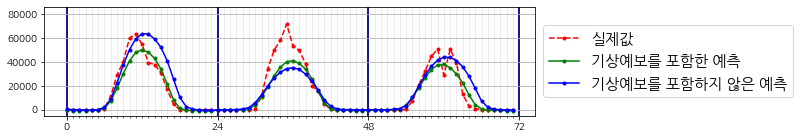

In [5]:
#humi

pred1=pred1_3.copy()
pred2=pred2_3.copy()
#y_t=data_hr1[-l:,0][idx]

fig = plt.figure(figsize=(11,2))                                                               
ax = fig.add_subplot(1,1,1)                                                      

# This is where I manually set ticks. Can I use Datetime data instead???                                     
major_ticks = np.arange(0, len(pred1)+1, 24)                                              
minor_ticks = np.arange(0, len(pred1)+1, 1)                                               

l=7*24#len(pred1)
plt.plot(y_t,marker='.',ls='--',c='r', label = '실제값')
ax.plot(pred1, 'g.-', label = '기상예보를 포함한 예측') 
ax.plot(pred2, 'b.-', label = '기상예보를 포함하지 않은 예측') 

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', prop={'size': 15}, bbox_to_anchor=(1, 0.5))

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
#ax.set_yticks(major_ticks)                                                       
#ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([0-5000,80000+6200])

ax.grid(which='both')                                                                                           
ax.grid(which='minor', alpha=0.3)                                                
ax.grid(which='major', alpha=1.0,linewidth=1.8,color='darkblue',axis='x')
plt.savefig('images/3.png')
plt.show()

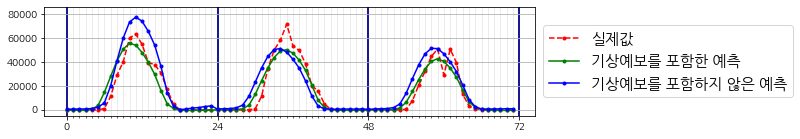

In [8]:
#humi, temp
pred1=pred1_03.copy()
pred2=pred2_03.copy()
#y_t=data_hr1[-l:,0][idx]

fig = plt.figure(figsize=(11,2))                                                               
ax = fig.add_subplot(1,1,1)                                                      

# This is where I manually set ticks. Can I use Datetime data instead???                                     
major_ticks = np.arange(0, len(pred1)+1, 24)                                              
minor_ticks = np.arange(0, len(pred1)+1, 1)                                               

l=7*24#len(pred1)
plt.plot(y_t,marker='.',ls='--',c='r', label = '실제값')
ax.plot(pred1, 'g.-', label = '기상예보를 포함한 예측') 
ax.plot(pred2, 'b.-', label = '기상예보를 포함하지 않은 예측') 

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', prop={'size': 15}, bbox_to_anchor=(1, 0.5))

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
#ax.set_yticks(major_ticks)                                                       
#ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([0-5000,80000+6200])

ax.grid(which='both')                                                                                           
ax.grid(which='minor', alpha=0.3)                                                
ax.grid(which='major', alpha=1.0,linewidth=1.8,color='darkblue',axis='x')
plt.savefig('images/03.png')
plt.show()

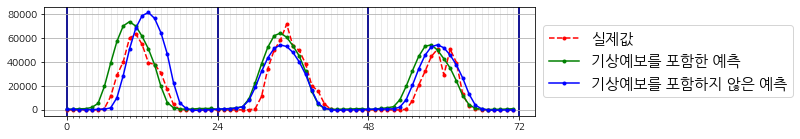

In [9]:
#humi, temp, rain
pred1=pred1_013.copy()
pred2=pred2_013.copy()
#y_t=data_hr1[-l:,0][idx]

fig = plt.figure(figsize=(11,2))                                                               
ax = fig.add_subplot(1,1,1)                                                      

# This is where I manually set ticks. Can I use Datetime data instead???                                     
major_ticks = np.arange(0, len(pred1)+1, 24)                                              
minor_ticks = np.arange(0, len(pred1)+1, 1)                                               

l=7*24#len(pred1)
plt.plot(y_t,marker='.',ls='--',c='r', label = '실제값')
ax.plot(pred1, 'g.-', label = '기상예보를 포함한 예측') 
ax.plot(pred2, 'b.-', label = '기상예보를 포함하지 않은 예측') 

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', prop={'size': 15}, bbox_to_anchor=(1, 0.5))

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
#ax.set_yticks(major_ticks)                                                       
#ax.set_yticks(minor_ticks, minor=True)
ax.set_ylim([0-5000,80000+6200])

ax.grid(which='both')                                                                                           
ax.grid(which='minor', alpha=0.3)                                                
ax.grid(which='major', alpha=1.0,linewidth=1.8,color='darkblue',axis='x')
plt.savefig('images/013.png')
plt.show()

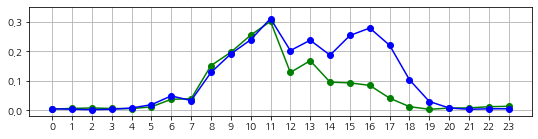

In [37]:
#humi
pred1=pred1_3.copy()
pred2=pred2_3.copy()
r_list1_3=[]
r_list2_3=[]
for i in range(24):
    y_t_tmp=y_t[[i,i+24,i+48]]
    pred1_tmp=pred1[[i,i+24,i+48]]
    pred2_tmp=pred2[[i,i+24,i+48]]
    r=np.sqrt(mean_squared_error(y_t_tmp,pred1_tmp))/np.max(y_t)
    r_list1_3.append(r)
    r=np.sqrt(mean_squared_error(y_t_tmp,pred2_tmp))/np.max(y_t)
    r_list2_3.append(r)

plt.figure(figsize=(9,2))
plt.plot(r_list1_3,'go-', label = '기상예보를 포함한 예측')
plt.plot(r_list2_3,'bo-', label = '기상예보를 포함하지 않은 예측')
#plt.legend()
plt.xticks(range(24))
plt.ylim(-0.02, 0.35)
plt.grid()

plt.savefig('images/error_3_2.png')
plt.show()

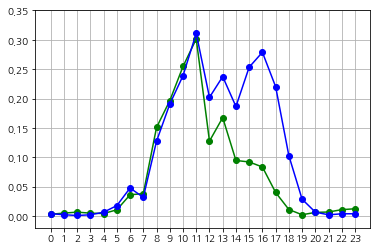

In [36]:
#humi
pred1=pred1_3.copy()
pred2=pred2_3.copy()
r_list1_3=[]
r_list2_3=[]
for i in range(24):
    y_t_tmp=y_t[[i,i+24,i+48]]
    pred1_tmp=pred1[[i,i+24,i+48]]
    pred2_tmp=pred2[[i,i+24,i+48]]
    r=np.sqrt(mean_squared_error(y_t_tmp,pred1_tmp))/np.max(y_t)
    r_list1_3.append(r)
    r=np.sqrt(mean_squared_error(y_t_tmp,pred2_tmp))/np.max(y_t)
    r_list2_3.append(r)

plt.plot(r_list1_3,'go-', label = '기상예보를 포함한 예측')
plt.plot(r_list2_3,'bo-', label = '기상예보를 포함하지 않은 예측')
#plt.legend()
plt.xticks(range(24))
plt.ylim(-0.02, 0.35)
plt.grid()

plt.savefig('images/error_3.png')
plt.show()

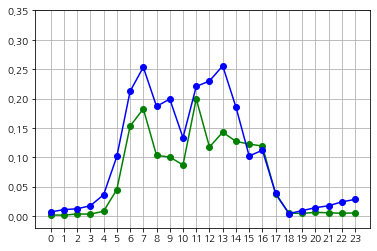

In [31]:
pred1=pred1_03.copy()
pred2=pred2_03.copy()
r_list1_03=[]
r_list2_03=[]
for i in range(24):
    y_t_tmp=y_t[[i,i+24,i+48]]
    pred1_tmp=pred1[[i,i+24,i+48]]
    pred2_tmp=pred2[[i,i+24,i+48]]
    r=np.sqrt(mean_squared_error(y_t_tmp,pred1_tmp))/np.max(y_t)
    r_list1_03.append(r)
    r=np.sqrt(mean_squared_error(y_t_tmp,pred2_tmp))/np.max(y_t)
    r_list2_03.append(r)

plt.plot(r_list1_03,'go-', label = '기상예보를 포함한 예측')
plt.plot(r_list2_03,'bo-', label = '기상예보를 포함하지 않은 예측')
#plt.legend()
plt.xticks(range(24))
plt.ylim(-0.02, 0.35)
plt.grid()

plt.savefig('images/error_03.png')
plt.show()

(-0.05, 0.4)

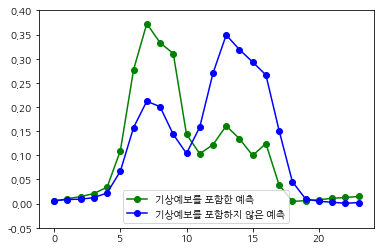

In [23]:
pred1=pred1_013.copy()
pred2=pred2_013.copy()
r_list1_013=[]
r_list2_013=[]
for i in range(24):
    y_t_tmp=y_t[[i,i+24,i+48]]
    pred1_tmp=pred1[[i,i+24,i+48]]
    pred2_tmp=pred2[[i,i+24,i+48]]
    r=np.sqrt(mean_squared_error(y_t_tmp,pred1_tmp))/np.max(y_t)
    r_list1_013.append(r)
    r=np.sqrt(mean_squared_error(y_t_tmp,pred2_tmp))/np.max(y_t)
    r_list2_013.append(r)

plt.plot(r_list1_013,'go-', label = '기상예보를 포함한 예측')
plt.plot(r_list2_013,'bo-', label = '기상예보를 포함하지 않은 예측')
plt.legend()
plt.ylim(-0.05, 0.4)

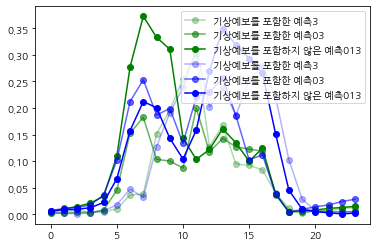

In [10]:
plt.plot(r_list1_3,'go-',alpha=0.3, label = '기상예보를 포함한 예측3')
plt.plot(r_list1_03,'go-',alpha=0.6, label = '기상예보를 포함한 예측03')
plt.plot(r_list1_013,'go-', alpha=1.0,label = '기상예보를 포함하지 않은 예측013')

plt.plot(r_list2_3,'bo-',alpha=0.3, label = '기상예보를 포함한 예측3')
plt.plot(r_list2_03,'bo-',alpha=0.6, label = '기상예보를 포함한 예측03')
plt.plot(r_list2_013,'bo-',alpha=1.0, label = '기상예보를 포함하지 않은 예측013')
plt.legend()

plt.legend()

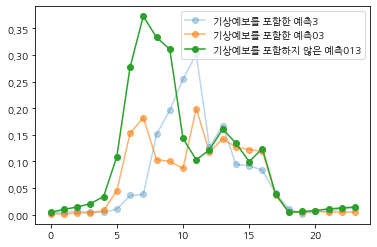

In [12]:
plt.plot(r_list1_3,'o-',alpha=0.3, label = '기상예보를 포함한 예측3')
plt.plot(r_list1_03,'o-',alpha=0.6, label = '기상예보를 포함한 예측03')
plt.plot(r_list1_013,'o-', alpha=1.0,label = '기상예보를 포함하지 않은 예측013')
plt.legend()

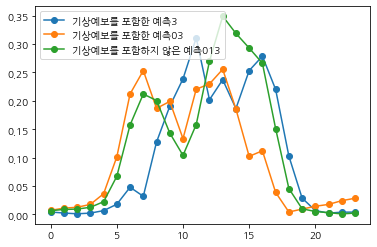

In [7]:
plt.plot(r_list2_3,'o-', label = '기상예보를 포함한 예측3')
plt.plot(r_list2_03,'o-', label = '기상예보를 포함한 예측03')
plt.plot(r_list2_013,'o-', label = '기상예보를 포함하지 않은 예측013')
plt.legend()

## with weather forecasting data(# of feature=7)

In [29]:
#only humi
l=7*24#len(pred1)
#y_true=(data_hr1[-l:,0])[idx]
y_true=y_t.copy()
r=np.sqrt(mean_squared_error(y_true,pred1_3))
print('rmse: %.3f'%r)
print('rmse/max',r/np.max(y_true)*100)
print('rmse/mean',r/np.mean(y_true)*100)
print('rmse/std',r/np.std(y_true)*100)
print('rmse/IQR',r/iqr(y_true)*100)
print('WAPE: ',np.mean(np.abs((y_true -pred1)/np.mean(y_true))))

rmse: 7911.905
rmse/max 11.004040133896286
rmse/mean 52.00448691359713
rmse/std 37.428570315360616
rmse/IQR 25.27765129799179
WAPE:  0.45358071146643414


In [4]:
# humi,temp
l=7*24#len(pred1)
y_true=(data_hr1[-l:,0])[idx]
r=np.sqrt(mean_squared_error(y_true,pred1))
print('rmse: %.3f'%r)
print('rmse/max',r/np.max(y_true)*100)
print('rmse/mean',r/np.mean(y_true)*100)
print('rmse/std',r/np.std(y_true)*100)
print('rmse/IQR',r/iqr(y_true)*100)
print('WAPE: ',np.mean(np.abs((y_true -pred1)/np.mean(y_true))))

rmse: 6691.165
rmse/max 9.306209610681805
rmse/mean 43.98063347870876
rmse/std 31.653657797007412
rmse/IQR 21.37752303540006
WAPE:  0.2785852717010344


In [48]:
#humi, temp, rain
l=7*24#len(pred1)
y_true=(data_hr1[-l:,0])[idx]
r=np.sqrt(mean_squared_error(y_true,pred1))
print('rmse: %.3f'%r)
print('rmse/max',r/np.max(y_true)*100)
print('rmse/mean',r/np.mean(y_true)*100)
print('rmse/std',r/np.std(y_true)*100)
print('rmse/IQR',r/iqr(y_true)*100)
print('WAPE: ',np.mean(np.abs((y_true -pred1)/np.mean(y_true))))

rmse: 10928.814
rmse/max 15.200019696315744
rmse/mean 71.83445496064209
rmse/std 51.7005571659052
rmse/IQR 34.9163391746039
WAPE:  0.45358071146643414


## without weather forecasting data(# of feature=4)

In [28]:
#humi
#y_true=(data_hr1[-l:,0])[idx]
y_true=y_t.copy()
r=np.sqrt(mean_squared_error(y_true,pred2_3))
print('rmse: %.3f'%r)
print('rmse/max',r/np.max(y_true)*100)
print('rmse/mean',r/np.mean(y_true)*100)
print('rmse/std',r/np.std(y_true)*100)
print('rmse/IQR',r/iqr(y_true)*100)
print('WAPE: ',np.mean(np.abs((y_true -pred2)/np.mean(y_true))))

rmse: 10819.204
rmse/max 15.04757191915733
rmse/mean 71.1139951717123
rmse/std 51.182029218227335
rmse/IQR 34.56614763538058
WAPE:  0.459225138261498


In [5]:
#humi, temp
r=np.sqrt(mean_squared_error(y_true,pred2))
print('rmse: %.3f'%r)
print('rmse/max',r/np.max(y_true)*100)
print('rmse/mean',r/np.mean(y_true)*100)
print('rmse/std',r/np.std(y_true)*100)
print('rmse/IQR',r/iqr(y_true)*100)
print('WAPE: ',np.mean(np.abs((y_true -pred2)/np.mean(y_true))))

rmse: 9749.299
rmse/max 13.559525974305252
rmse/mean 64.08157208671119
rmse/std 46.120667063810814
rmse/IQR 31.1479206885798
WAPE:  0.4321553752342671


In [49]:
#humi, temp, rain
r=np.sqrt(mean_squared_error(y_true,pred2))
print('rmse: %.3f'%r)
print('rmse/max',r/np.max(y_true)*100)
print('rmse/mean',r/np.mean(y_true)*100)
print('rmse/std',r/np.std(y_true)*100)
print('rmse/IQR',r/iqr(y_true)*100)
print('WAPE: ',np.mean(np.abs((y_true -pred2)/np.mean(y_true))))

rmse: 11831.916
rmse/max 16.456072210030968
rmse/mean 77.77048988213284
rmse/std 55.97282891858279
rmse/IQR 37.801648303553556
WAPE:  0.459225138261498


# ====================================================

In [ ]:
rmse=[]
rmse_max=[]
rmse_mean=[]
rmse_std=[]
rmse_iqr=[]
wape=[]

for i in range(1,1+4):
    y_true=(data_hr1[-len(pred1):,0])[i*24:(i+1)*24]
    r=np.sqrt(mean_squared_error(y_true,pred1[i*24:(i+1)*24]))
    rmse.append(r)
    rmse_max.append(r/np.max(y_true)*100)
    rmse_mean.append(r/mean(y_true)*100)
    rmse_std.append(r/np.std(y_true)*100)
    rsme_iqr.append(r/np.iqr(y_true)*100)
    wape.append()
    print('rmse: %.3f'%r)
    print('rmse/max',r/np.max(y_true)*100)
    print('rmse/mean',)
    print('rmse/std',)
    print('rmse/IQR',r/iqr(y_true)*100)
    print('WAPE: ',np.mean(np.abs((y_true -pred1[i*24:(i+1)*24])/np.mean(y_true))))

In [47]:
print("with weather forcasting data prediction error",np.mean(nrmse[0]))
print("without weather forcasting data prediction error",np.mean(nrmse[1]))

with weather forcasting data prediction error 0.2156277707475779
without weather forcasting data prediction error 0.22391830086663161


(168,)


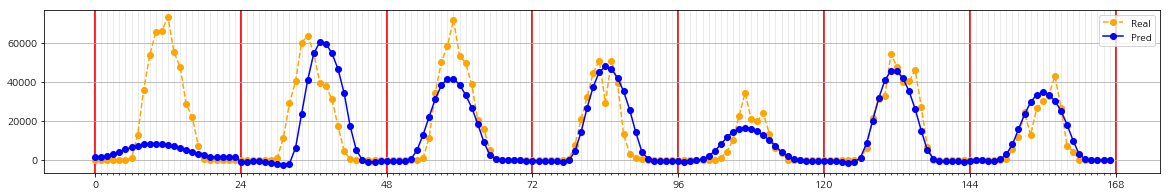

In [5]:
pred1= model.predict(X_test)
pred1=pred1.reshape(-1,1)
pred1 = sc1.inverse_transform(pred1)
pred1=pred1[:,0]
print(pred1.shape)

fig = plt.figure(figsize=(20,3))                                                               
ax = fig.add_subplot(1,1,1)                                                      

# This is where I manually set ticks. Can I use Datetime data instead???                                     
major_ticks = np.arange(0, len(pred1)+1, 24)                                              
minor_ticks = np.arange(0, len(pred1)+1, 1)                                               

plt.plot(data_hr1[-len(pred1):,0],marker='o',ls='--',c='orange', label = 'Real')
ax.plot(pred1, 'bo-', label = 'Pred') 
ax.legend()

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
#ax.set_yticks(major_ticks)                                                       
#ax.set_yticks(minor_ticks, minor=True)                                           
ax.grid(which='both')                                                                                           
ax.grid(which='minor', alpha=0.3)                                                
ax.grid(which='major', alpha=1.0,linewidth=1.8,color='r',axis='x')
plt.savefig('tmp.png')
plt.show()

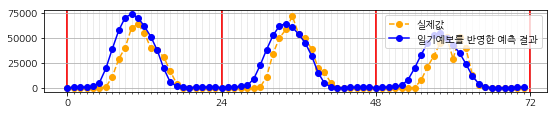

In [42]:
fig = plt.figure(figsize=(9,1.5))                                                               
ax = fig.add_subplot(1,1,1)                                                      

# This is where I manually set ticks. Can I use Datetime data instead???                                     
major_ticks = np.arange(0, len(pred1)+1, 24)                                              
minor_ticks = np.arange(0, len(pred1)+1, 1)                                               

l=7*24#len(pred1)
plt.plot(data_hr1[-l:,0][idx],marker='o',ls='--',c='orange', label = '실제값')
ax.plot(pred1, 'bo-', label = '일기예보를 반영한 예측 결과') 
ax.legend()

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
#ax.set_yticks(major_ticks)                                                       
#ax.set_yticks(minor_ticks, minor=True)                                           
ax.grid(which='both')                                                                                           
ax.grid(which='minor', alpha=0.3)                                                
ax.grid(which='major', alpha=1.0,linewidth=1.8,color='r',axis='x')
plt.savefig('tmp.png')
plt.show()

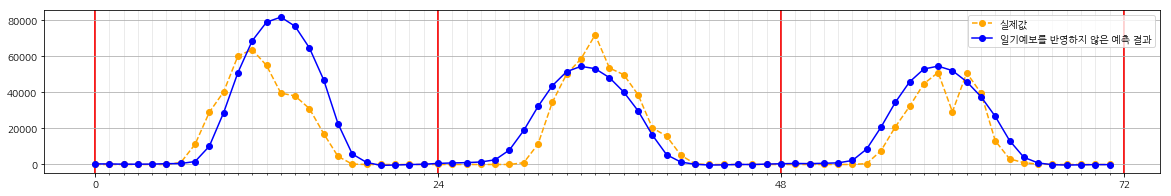

In [44]:
fig = plt.figure(figsize=(20,3))                                                               
ax = fig.add_subplot(1,1,1)                                                      

# This is where I manually set ticks. Can I use Datetime data instead???                                     
major_ticks = np.arange(0, len(pred1)+1, 24)                                              
minor_ticks = np.arange(0, len(pred1)+1, 1)                                               

l=7*24#len(pred1)
plt.plot(data_hr1[-l:,0][idx],marker='o',ls='--',c='orange', label = '실제값')
ax.plot(pred2, 'bo-', label = '일기예보를 반영하지 않은 예측 결과') 
ax.legend()

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
#ax.set_yticks(major_ticks)                                                       
#ax.set_yticks(minor_ticks, minor=True)                                           
ax.grid(which='both')                                                                                           
ax.grid(which='minor', alpha=0.3)                                                
ax.grid(which='major', alpha=1.0,linewidth=1.8,color='r',axis='x')
plt.savefig('tmp.png')
plt.show()

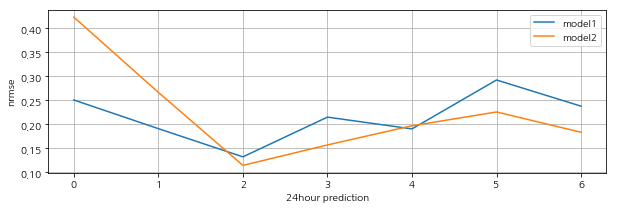

In [58]:
#rmse/max
pred=[pred1,pred2]
nrmse=[]
for j in range(len(pred)):
    nrmsei=[]
    for i in range(7):
        r=np.sqrt(mean_squared_error(y_true[i*24:(i+1)*24],(pred[j])[i*24:(i+1)*24]))
        nrmsei.append(r/np.max(y_true[i*24:(i+1)*24]))
    nrmse.append(nrmsei)
nrmse=np.array(nrmse);nrmse.shape

fig = plt.figure(figsize=(10,3))
for i in range(len(nrmse)):
    plt.plot(nrmse[i],label="model"+str(i+1))
plt.legend()
plt.grid()
plt.ylabel("nrmse")
plt.xlabel("24hour prediction")
plt.show()